In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

import pandas as pd
import h5py
import meshio
from torch_geometric.data import Data

np.random.seed(1234)

In [2]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

Using device: cuda
NVIDIA GeForce GTX 1650


In [3]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [4]:
class PINN():
    def __init__(self, X, Y, masks, layers, h, l, r, nu):
        self.x = torch.tensor(X, requires_grad=True).float().to(device).view(-1, 1)
        self.y = torch.tensor(Y, requires_grad=True).float().to(device).view(-1, 1)
        self.data = torch.cat((self.x, self.y), dim=1)

        self.mask_left = masks['left']
        self.mask_top = masks['top']
        self.mask_right = masks['right']
        self.mask_down = masks['down']
        self.mask_hole = masks['hole']

        self.nu = nu

        self.h = h
        self.l = l
        self.r = r

        self.track_loss = []

        self.w_pde = 1
        self.w_bc = 1
        self.lr_adam = 0.01
        self.lr_lbfgs = 0.005

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=self.lr_lbfgs,
            max_iter=10000,
            max_eval=10000,
            history_size=200,
            tolerance_grad=1e-20,
            tolerance_change=1e-20,
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=self.lr_adam)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=4000, gamma=0.5)
        self.iter = 0

    def model_value(self, data):
        out = self.dnn(data)
        u = out[:,0:1]
        v = out[:,1:2]
        sxx = out[:,2:3]
        syy = out[:,3:4]
        sxy = out[:,4:5]
        return u, v, sxx, syy, sxy

    def pde_loss(self, u, v, sxx, syy, sxy, data):

        du = torch.autograd.grad(u, data, torch.ones_like(u), create_graph=True)[0]
        dx_u = du[:, 0:1]
        dy_u = du[:, 1:2]

        dv = torch.autograd.grad(v, data, torch.ones_like(v), create_graph=True)[0]
        dx_v = dv[:, 0:1]
        dy_v = dv[:, 1:2]

        dx_sxx = torch.autograd.grad(sxx, data, torch.ones_like(sxx), create_graph=True)[0][:, 0:1]
        dy_syy = torch.autograd.grad(syy, data, torch.ones_like(syy), create_graph=True)[0][:, 1:2]
        dsxy = torch.autograd.grad(sxy, data, torch.ones_like(sxy), create_graph=True)[0]
        dx_sxy = dsxy[:, 0:1]
        dy_sxy = dsxy[:, 1:2]

        term_xx = 1 / (1 - self.nu**2) * (dx_u + self.nu*dy_v)
        term_yy = 1 / (1 - self.nu**2) * (dy_v + self.nu*dx_u)
        term_xy = 1 / (2*(1 + self.nu)) * (dy_u + dx_v)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dx_sxx + dy_sxy), 2))
        r5 = torch.mean(torch.pow((dy_syy + dx_sxy), 2))

        residual = r1 + r2+ r3 + r4 + r5
        return residual

    def bc_loss(self, u, v, sxx, syy, sxy, data):

        b = torch.mean(torch.pow(u[self.mask_left], 2))
        b += torch.mean(torch.pow(v[self.mask_left], 2))

        b += torch.mean(torch.pow(syy[self.mask_top], 2))
        b += torch.mean(torch.pow(sxy[self.mask_top], 2))

        b += torch.mean(torch.pow(sxx[self.mask_right] - 1, 2))
        b += torch.mean(torch.pow(sxy[self.mask_right], 2))

        b += torch.mean(torch.pow(syy[self.mask_down], 2))
        b += torch.mean(torch.pow(sxy[self.mask_down], 2))

        # x = data[:, 0:1]
        # y = data[:, 1:2]
        # nx = -(x[self.mask_hole]-self.l/2)/self.r
        # ny = -(y[self.mask_hole]-self.h/2)/self.r
        # tx = torch.mul(sxx[self.mask_hole], nx) + torch.mul(sxy[self.mask_hole], ny)
        # ty = torch.mul(sxy[self.mask_hole], nx) + torch.mul(syy[self.mask_hole], ny)

        # b += torch.mean(torch.pow(tx, 2))
        # b += torch.mean(torch.pow(ty, 2))

        return b

    
    def loss_func(self):
        u, v, sxx, syy, sxy = self.model_value(self.data)
        pde = self.pde_loss(u, v, sxx, syy, sxy, self.data)
        bc = self.bc_loss(u, v, sxx, syy, sxy, self.data)
        return pde, bc


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func()
        loss = self.w_pde*pde_loss + self.w_bc*bc_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        self.track_loss.append(loss.item())

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func()
            loss = self.w_pde*pde_loss + self.w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            self.scheduler.step()

            self.track_loss.append(loss.item())

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, y):
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)
        data = torch.cat((x, y), dim=1)

        self.dnn.eval()
        u, v, sxx, syy, sxy = self.model_value(data)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        sxx = sxx.detach().cpu().numpy()
        syy = syy.detach().cpu().numpy()
        sxy = sxy.detach().cpu().numpy()
        return u, v, sxx, syy, sxy

In [5]:
def generate_points(pd, pb, l, h, r):
    a = l / 2
    b = h / 2

    area = r**2 * np.pi
    p_new = int(pd * (1+area)) # Increase amount of points with percantage of circle covering

    dom = lhs(2, p_new)
    # mask = np.sqrt((dom[:,0]*l - a)**2 + (dom[:,1]*h - b)**2) >= r
    # dom = dom[mask]
    dom_x = dom[:,0] * l
    dom_y = dom[:,1] * h

    left_x = np.zeros(pb)
    left_y = (lhs(1, pb) * h).flatten()


    top_x = (lhs(1, pb) * l).flatten()
    top_y = np.ones(pb) * h

    right_x = np.ones(pb) * l
    right_y = (lhs(1, pb) * h).flatten()

    down_x = (lhs(1, pb) * l).flatten()
    down_y = np.zeros(pb)

    theta = np.random.uniform(0, 2*np.pi, pb)
    hole_x = a + r*np.cos(theta)
    hole_y = b + r*np.sin(theta)

    dom_x = np.hstack((dom_x, hole_x, left_x, top_x, right_x, down_x))
    dom_y = np.hstack((dom_y, hole_y, left_y, top_y, right_y, down_y))

    X = {'dom': dom_x, 'left': left_x, 'top': top_x, 'right': right_x, 'down': down_x, 'hole': hole_x}
    Y = {'dom': dom_y, 'left': left_y, 'top': top_y, 'right': right_y, 'down': down_y, 'hole': hole_y}
    return X, Y

In [ ]:
l = 2
h = 1
r = 0.15
E = 1
nu = 0.3


X, Y = generate_points(10000, 2000, l, h, r)

nodes = 64
layers = [2] + 5 * [nodes] + [5]

In [7]:

dom_x = X['dom']
dom_y = Y['dom']

mask_left = np.equal(dom_x, 0)
mask_top = np.equal(dom_y, h)
mask_right = np.equal(dom_x, l)
mask_down = np.equal(dom_y, 0)
rad = np.sqrt((dom_x - l/2)**2 + (dom_y - h/2)**2)
mask_hole = np.isclose(rad, r)

print(dom_x[mask_hole].shape)

masks = {
    'left': mask_left,
    'top': mask_top,
    'right': mask_right, 
    'down': mask_down,
    'hole': mask_hole
}


(2000,)


In [8]:
model = PINN(dom_x, dom_y, masks, layers, h, l, r, nu)

In [9]:
print(model.dnn)

DNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): Tanh()
    (10): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [ ]:
model.train(4000)

Epoch 0, Loss: 9.227928e-01
PDE: 4.144252e-01, BC: 5.083677e-01
Epoch 100, Loss: 8.926935e-03
PDE: 2.224995e-03, BC: 6.701940e-03
Epoch 200, Loss: 6.434160e-03
PDE: 1.209700e-03, BC: 5.224459e-03
Epoch 300, Loss: 5.416526e-03
PDE: 1.162051e-03, BC: 4.254475e-03
Epoch 400, Loss: 6.614973e-03
PDE: 1.510385e-03, BC: 5.104588e-03
Epoch 500, Loss: 5.112599e-03
PDE: 1.196441e-03, BC: 3.916157e-03
Epoch 600, Loss: 4.843988e-03
PDE: 1.142964e-03, BC: 3.701024e-03
Epoch 700, Loss: 4.648872e-03
PDE: 1.099152e-03, BC: 3.549720e-03
Epoch 800, Loss: 4.425047e-03
PDE: 1.072003e-03, BC: 3.353044e-03
Epoch 900, Loss: 3.555974e-02
PDE: 2.845827e-02, BC: 7.101469e-03
Epoch 1000, Loss: 4.574208e-03
PDE: 1.073703e-03, BC: 3.500505e-03
Epoch 1100, Loss: 4.231312e-03
PDE: 1.056717e-03, BC: 3.174595e-03
Epoch 1200, Loss: 3.931033e-03
PDE: 1.091658e-03, BC: 2.839375e-03
Epoch 1300, Loss: 4.440592e-03
PDE: 1.133041e-03, BC: 3.307552e-03
Epoch 1400, Loss: 3.930908e-03
PDE: 1.128991e-03, BC: 2.801917e-03
Epoch 1

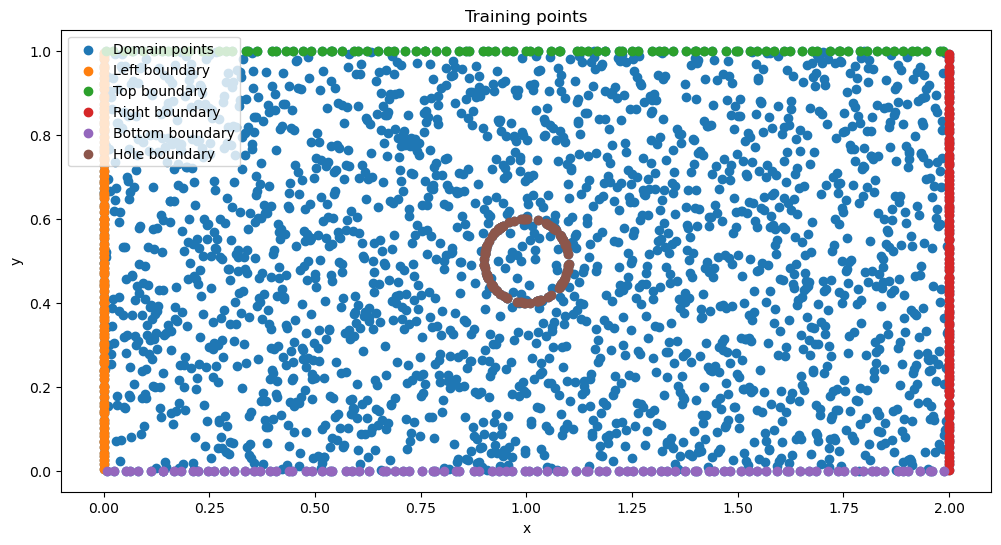

In [26]:
plt.figure(figsize=(12, 6))

plt.scatter(X['dom'], Y['dom'], label="Domain points")
plt.scatter(X['left'], Y['left'], label="Left boundary")
plt.scatter(X['top'], Y['top'], label="Top boundary")
plt.scatter(X['right'], Y['right'], label="Right boundary")
plt.scatter(X['down'], Y['down'], label="Bottom boundary")
plt.scatter(X['hole'], Y['hole'], label="Hole boundary")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training points")
plt.legend(loc="upper left")
plt.show()

In [69]:
x_p = 100
y_p = 100

x = np.linspace(0, l, x_p)
y = np.linspace(0, h, y_p)
X, Y = np.meshgrid(x, y)

points = np.vstack((X.ravel(), Y.ravel())).T

distances = np.sqrt((points[:, 0] - l/2)**2 + (points[:, 1] - h/2)**2)
filtered_points = points[distances > r]

x_pred = filtered_points[:, 0].reshape(-1, 1)
y_pred = filtered_points[:, 1].reshape(-1, 1)

x = torch.tensor(x_pred).float().to(device)
y = torch.tensor(y_pred).float().to(device)
data = torch.cat((x, y), dim=1)

u, v, sxx, syy, sxy = model.model_value(data)

In [70]:
u = u.detach().cpu().numpy()
v = v.detach().cpu().numpy()
sxx = sxx.detach().cpu().numpy()
syy = syy.detach().cpu().numpy()
sxy = sxy.detach().cpu().numpy()

In [71]:
L = 2  # Length of the sheet
H = 1   # Height of the sheet
nx, ny = 10, 10  # Number of grid points in x and y
E = 7e10  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

u1 = u*U
v1 = v*U
sxx1 = sxx*sigma_0
syy1 = syy*sigma_0
sxy1 = sxy*sigma_0


In [72]:
von_mises = np.sqrt(sxx1**2 + syy1**2 - sxx1*syy1 + 3*sxy1**2)
print(von_mises)

[[54370828.]
 [52980516.]
 [51965336.]
 ...
 [50365912.]
 [50332588.]
 [50314052.]]


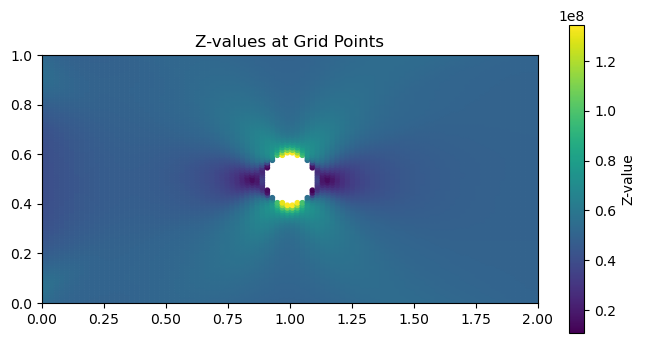

In [73]:
plt.figure(figsize=(8, 4))
sc = plt.scatter(x_pred, y_pred, c=von_mises, cmap='viridis', s=10)
plt.colorbar(sc, label="Z-value")
plt.title("Z-values at Grid Points")
plt.xlim(0, l)
plt.ylim(0, h)
plt.gca().set_aspect('equal')
plt.show()

In [74]:
# Save model
torch.save(model.dnn.state_dict(), "models/plate_hole_2.pth")

In [57]:
# Load model
model = PINN(dom_x, dom_y, masks, layers, h, l, r, nu)
model.dnn.load_state_dict(torch.load("models/plate_hole_1.pth", weights_only=True))

<All keys matched successfully>

In [75]:
mesh_file = "meshes/hole_middle_r10_o1.inp"
csv_file = "meshes/hole_middle_r10_al.csv"

mesh = meshio.read(mesh_file)
df = pd.read_csv(csv_file, sep=',', skipinitialspace=True)

In [88]:
von_miss = df["Equivalent Stress"].values
nodes = mesh.points[:,:2]
a = len(nodes)
node_features = torch.tensor(von_miss[:a], dtype=torch.float).view(-1, 1)

print(len(nodes))

print(len(node_features[:a]))

5529
5529


In [89]:
edges = []
for cell in mesh.cells:
    if cell.type == "triangle":
        for element in cell.data:
            edges.append([element[0], element[1]])
            edges.append([element[1], element[0]])

            edges.append([element[1], element[2]])
            edges.append([element[2], element[1]])

            edges.append([element[2], element[0]])
            edges.append([element[0], element[2]])

edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
pos = torch.tensor(nodes, dtype=torch.float)

data = Data(x=node_features, edge_index=edges, pos=pos)
print(data.x.shape)
print(data.pos.shape)

torch.Size([5529, 1])
torch.Size([5529, 2])


In [90]:
x = pos[:, 0:1].detach().cpu().numpy()
y = pos[:, 1:2].detach().cpu().numpy()

u, v, sxx, syy, sxy = model.predict(x, y)

E = 7e10  # Young's modulus (Pa)
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0
von_mises = np.sqrt(sxx**2 + syy**2 - sxx*syy + 3*sxy**2)

In [91]:
fem_von = node_features.detach().cpu().numpy()
print(fem_von)

[[87043896.]
 [49995092.]
 [49996028.]
 ...
 [79613176.]
 [32055406.]
 [38843548.]]


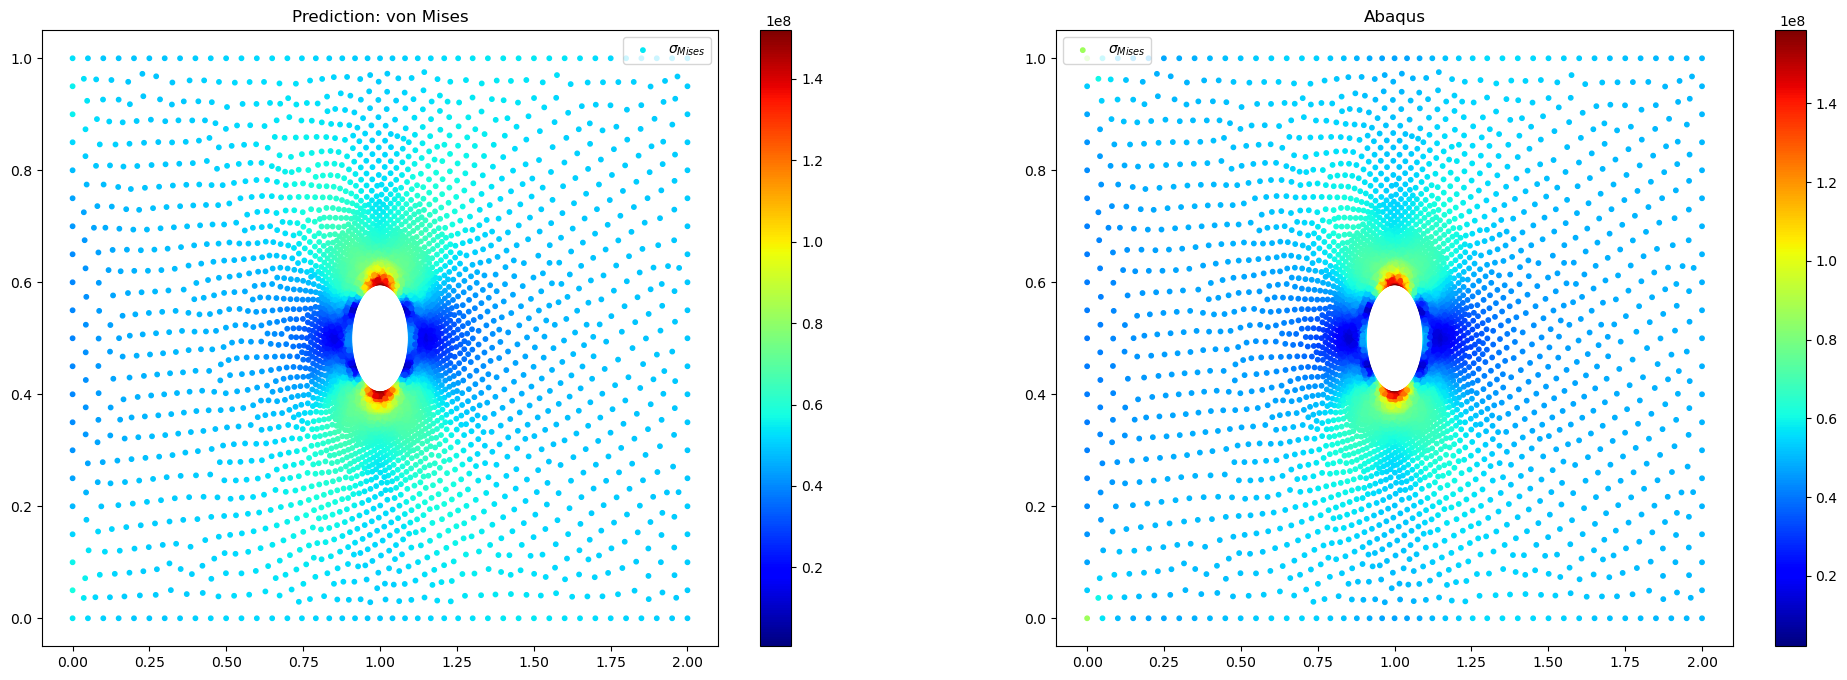

In [92]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharex=True)

color_map = 'jet'

sc1 = ax1.scatter(x, y, c=von_mises, cmap=color_map, s=10, label=r'$\sigma_{Mises}$')
ax1.legend(loc='upper right')
ax1.set_title('Prediction: von Mises')

plt.colorbar(sc1)

sc2 = ax2.scatter(x, y, c=fem_von, cmap=color_map, s=10, label=r'$\sigma_{Mises}$')
ax2.legend(loc='upper left')
ax2.set_title('Abaqus')
plt.colorbar(sc2)

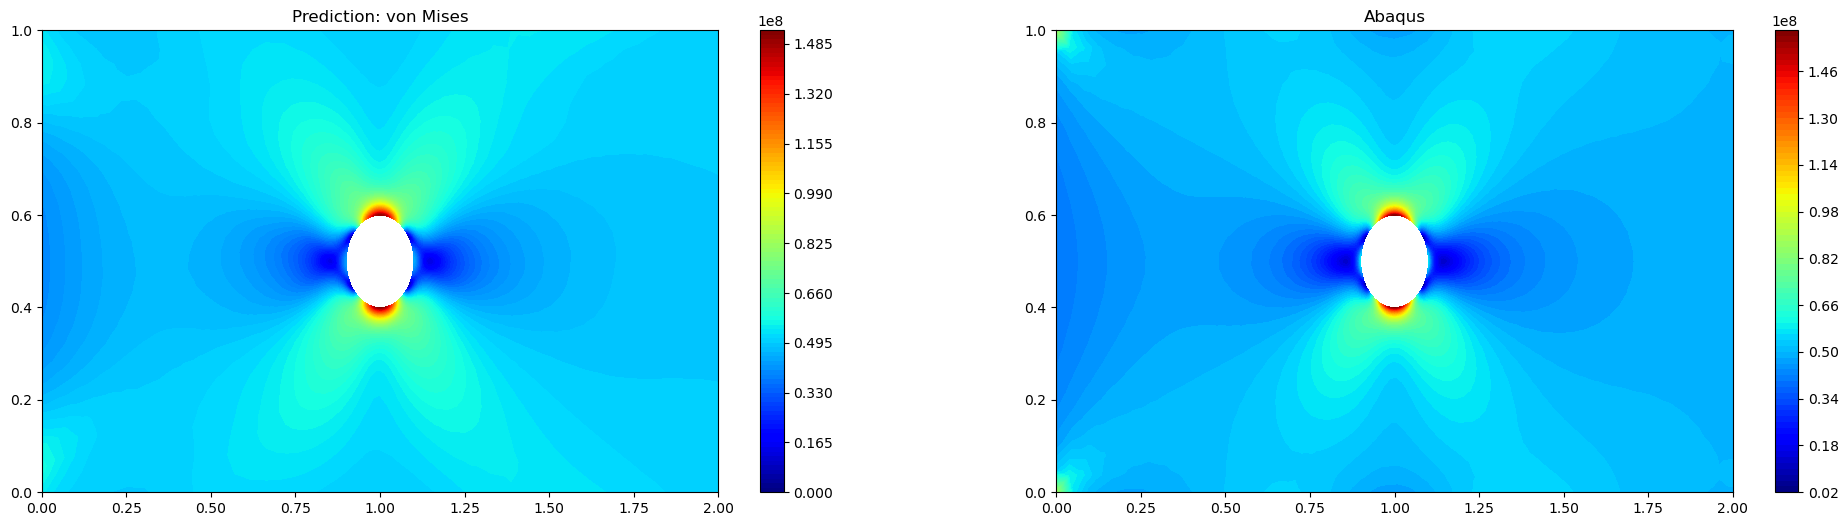

In [ ]:
import matplotlib.tri as tri

triang = tri.Triangulation(x.flatten(), y.flatten())

x_tri = x.flatten()[triang.triangles].mean(axis=1)
y_tri = y.flatten()[triang.triangles].mean(axis=1)

hole_center = (1.0, 0.5)
hole_radius = 0.1

mask = (x_tri - hole_center[0])**2 + (y_tri - hole_center[1])**2 < hole_radius**2
triang.set_mask(mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharex=True)

color_map = 'jet'

sc1 = ax1.tricontourf(triang, von_mises.flatten(), levels = 100, cmap='jet')
ax1.set_title('Prediction: von Mises')
plt.colorbar(sc1)

sc2 = ax2.tricontourf(triang, fem_von.flatten(), levels = 100, cmap='jet')
ax2.set_title('Ansys')
plt.colorbar(sc2)

plt.show()

(5529,)


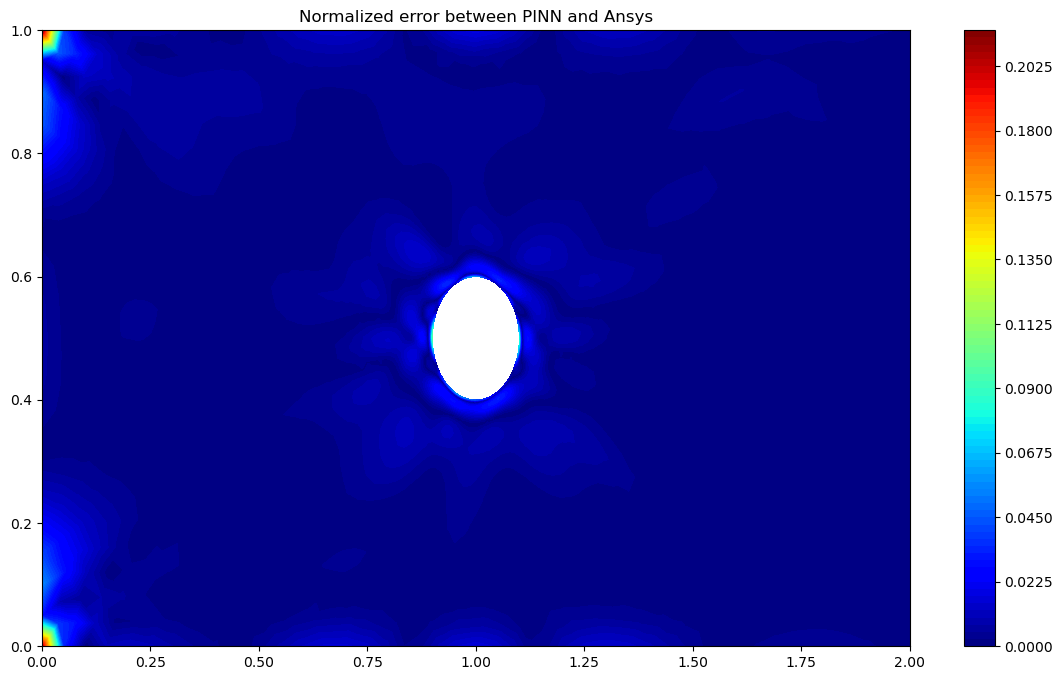

In [99]:
absolute_error = np.abs(von_mises - fem_von).flatten()
normalized_error = np.abs(von_mises - fem_von) / np.max(fem_von)

print(absolute_error.shape)

plt.figure(figsize=(14, 8))
plt.tricontourf(triang, normalized_error.flatten(), levels=100, cmap=color_map)
plt.title('Normalized error between PINN and Ansys')
plt.colorbar()
plt.show()

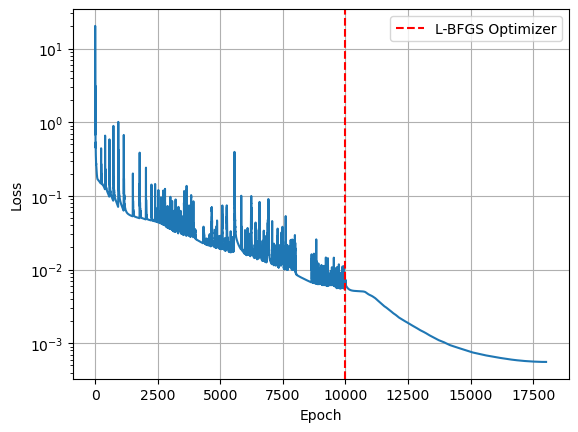

In [110]:
loss = model.track_loss

plt.semilogy(loss)
plt.axvline(x=10000, color='r', linestyle='--', label='L-BFGS Optimizer')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()